Number of gates in the circuit: 89


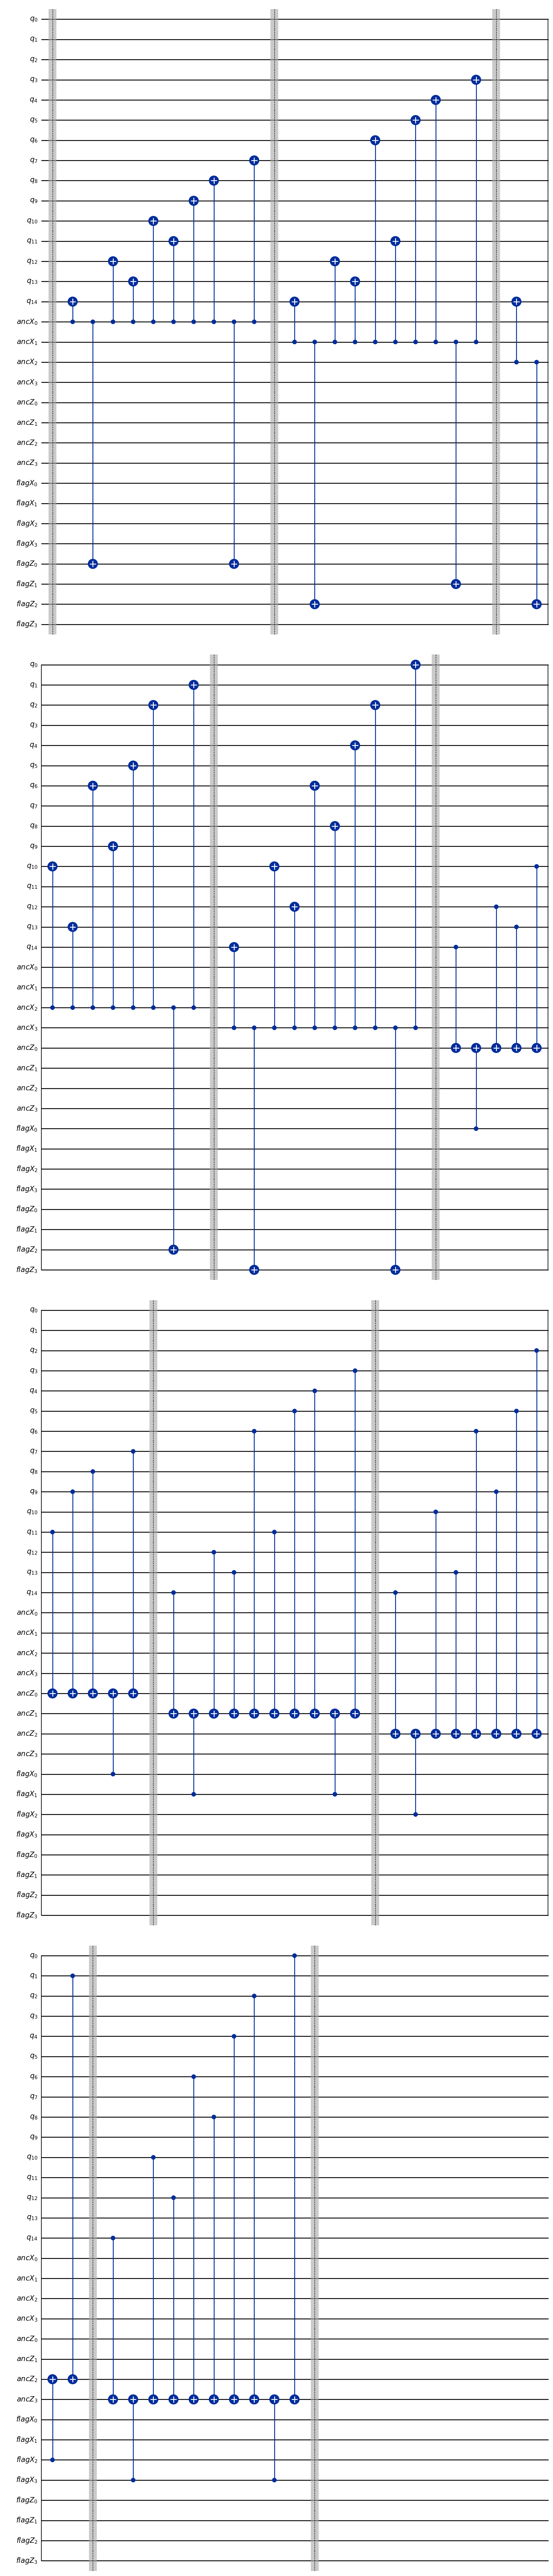

In [58]:
from qiskit import QuantumCircuit
from flag_analysis import *

dir_path = "/Users/wuboris/Desktop/flag verification/[[15,7,3]]_[1,1,1...]/"
qasm_path = dir_path + "[[15,7,3]]_flag.qasm"
txt_path = dir_path + "[[15,7,3]].txt"
# Load circuit from QASM file
qc = QuantumCircuit.from_qasm_file(qasm_path)


num_gates = sum(1 for inst in qc.data )
print(f"Number of gates in the circuit: {num_gates}")
# Draw the circuit (matplotlib drawer)
qc.draw("mpl", filename= dir_path + "[[15,7,3]]_flag.png")



In [59]:
from flag_analysis import *
# Build
state, qc, varenv = build_variable_state_from_qasm(qasm_path)
groups = detect_qubit_groups(qc)

# Flip predicates (basis-aware)
synX_exprs = ancillas_X(state, groups["ancX"])   # X-type syndromes (check .z)
synZ_exprs = ancillas_Z(state, groups["ancZ"])   # Z-type syndromes (check .x)
flgX_exprs = flags_X(state, groups["flagX"])     # flags measured in X (check .z)
flgZ_exprs = flags_Z(state, groups["flagZ"])     # flags measured in Z (check .x)

# Build an assignment:
# - allow arbitrary data errors via named vars (you can set a subset True)
# - force all anc/flag variables to False to model "no circuit faults"
asgmt = {}

# Force all anc/flag vars False:
for name in varenv:
    if name.startswith("ancX") or name.startswith("ancZ") or name.startswith("flagX") or name.startswith("flagZ"):
        asgmt[name] = False

# Example 1: single X error on q[3]  (Steane’s first X-stabilizer should click)

# (all other q*_x/z default to False)

# Evaluate syndromes/flags
synX_vals = [eval_under(e, asgmt, varenv) for e in synX_exprs]
synZ_vals = [eval_under(e, asgmt, varenv) for e in synZ_exprs]
flgX_vals = [eval_under(e, asgmt, varenv) for e in flgX_exprs]
flgZ_vals = [eval_under(e, asgmt, varenv) for e in flgZ_exprs]

print("AncX (X-type) syndromes:", synX_vals)
print("AncZ (Z-type) syndromes:", synZ_vals)
print("Flags X-basis:", flgX_vals)
print("Flags Z-basis:", flgZ_vals)

AncX (X-type) syndromes: [Not(((((((q14_z == q12_z) == q13_z) == q10_z) == q11_z) ==
      q9_z) ==
     q8_z) ==
    q7_z), Not(((((((q14_z == q12_z) == q13_z) == q6_z) == q11_z) ==
      q5_z) ==
     q4_z) ==
    q3_z), Not(((((((q14_z == q10_z) == q13_z) == q6_z) == q9_z) ==
      q5_z) ==
     q2_z) ==
    q1_z), Not(((((((q14_z == q10_z) == q12_z) == q6_z) == q8_z) ==
      q4_z) ==
     q2_z) ==
    q0_z)]
AncZ (Z-type) syndromes: [Not(((((((q14_x == q12_x) == q13_x) == q10_x) == q11_x) ==
      q9_x) ==
     q8_x) ==
    q7_x), Not(((((((q14_x == q12_x) == q13_x) == q6_x) == q11_x) ==
      q5_x) ==
     q4_x) ==
    q3_x), Not(((((((q14_x == q10_x) == q13_x) == q6_x) == q9_x) ==
      q5_x) ==
     q2_x) ==
    q1_x), Not(((((((q14_x == q10_x) == q12_x) == q6_x) == q8_x) ==
      q4_x) ==
     q2_x) ==
    q0_x)]
Flags X-basis: [False, False, False, False]
Flags Z-basis: [False, False, False, False]


In [60]:
# Build circuit state first, to get varenv with q{i}_x/z
state, qc, varenv = build_variable_state_from_qasm(qasm_path)

#print("varenv:", varenv)
# Load stabilizers
stabs = load_symplectic_txt(txt_path)
#print("Stabilizers:", stabs)
# Get Boolean formulas
stab_exprs = [anticomm_formula(Sx, Sz, varenv) for Sx,Sz in stabs]

for i, e in enumerate(stab_exprs):
    print(f"Stabilizer {i} formula:", e)



Stabilizer 0 formula: Xor(Xor(Xor(Xor(Xor(Xor(Xor(Xor(False, q7_z), q8_z), q9_z),
                    q10_z),
                q11_z),
            q12_z),
        q13_z),
    q14_z)
Stabilizer 1 formula: Xor(Xor(Xor(Xor(Xor(Xor(Xor(Xor(False, q3_z), q4_z), q5_z),
                    q6_z),
                q11_z),
            q12_z),
        q13_z),
    q14_z)
Stabilizer 2 formula: Xor(Xor(Xor(Xor(Xor(Xor(Xor(Xor(False, q1_z), q2_z), q5_z),
                    q6_z),
                q9_z),
            q10_z),
        q13_z),
    q14_z)
Stabilizer 3 formula: Xor(Xor(Xor(Xor(Xor(Xor(Xor(Xor(False, q0_z), q2_z), q4_z),
                    q6_z),
                q8_z),
            q10_z),
        q12_z),
    q14_z)
Stabilizer 4 formula: Xor(Xor(Xor(Xor(Xor(Xor(Xor(Xor(False, q7_x), q8_x), q9_x),
                    q10_x),
                q11_x),
            q12_x),
        q13_x),
    q14_x)
Stabilizer 5 formula: Xor(Xor(Xor(Xor(Xor(Xor(Xor(Xor(False, q3_x), q4_x), q5_x),
                  

In [61]:
from flag_analysis import check_ancillas_match_symplectic_ordered

report = check_ancillas_match_symplectic_ordered(
    qasm_path,
    txt_path,
    order="X-then-Z"   # change to "Z-then-X" if your .txt lists Z-first
)

print("OK?", report["ok"])

print("Mismatches:", report["mismatches"])

OK? True
Mismatches: []


In [62]:
from flag_analysis import *
from functools import reduce

bad_locations_dict = [] # List to store bad locations for the current circuit



for i in range(num_gates):  # Iterate over gates in the subcircuit
    
    circuit_bad_locations = []
    if qc.data[i].name  in ["barrier", "measure", "reset"]:
        continue  # Skip non-unitary gates

    
    state, qc, site_info, groups = build_state_with_fault_after_gate(
           qasm_path,
        gate_index=i,
        fault_mode="2q"
    )
    
    # Extract fault variables
    fault_var = [v for k, v in site_info["vars"].items() if k.startswith("f")]

    # Extract qubit groups
    data_idxs = groups["data"]
    ancz_idxs = groups["ancZ"]
    flagx_idxs = groups["flagX"]
    ancx_idxs = groups["ancX"]
    flagz_idxs = groups["flagZ"]

    # Extract error components
    E_x = [state.qubits[i].x for i in data_idxs]
    E_z = [state.qubits[i].z for i in data_idxs]

    # Inject flag errors
    if flagx_idxs:
        flag_var = [inject_flag_symbolic_one_axis(state, flag, axis="x", prefix="flagErr") for flag in flagx_idxs ]
    if flagz_idxs:
        flag_var = [inject_flag_symbolic_one_axis(state, flag, axis="z", prefix="flagErr") for flag in flagz_idxs ]

    # Build stabilizer-equivalent errors
    Epx, Epz, gsel = build_stab_equiv_errors(E_x, E_z, txt_path)

    # Build per-qubit error indicators
    b = [Or(xi, zi) for xi, zi in zip(Epx, Epz)]

    # Create a Z3 solver
    from z3 import Solver, Or, PbLe, ForAll, Xor, Implies, Exists
    s = Solver()
    #s.add(ForAll(fault_var, Implies(Or(fault_var), Exists(gsel, PbLe([(bi, 1) for bi in b], 1)))))
    s.add(ForAll(gsel, PbGe([(bi, 1) for bi in b], 2)  ) )
    s.add(Or(fault_var))  # At most one fault
    

    # Check satisfiability
    print("i ", i, s.check())
    if s.check() == sat:
        print("Bad location found at gate index:", i)
        print("qc.instructions ", qc.data[i].name, qc.data[i].qubits)
    
        # Store bad locations and gate numbers for the current subcircuit
        bad_locations_dict.append(i)

# Update the gate count for the next subcircuit




# Print the results
print("Bad locations:")
print(bad_locations_dict)


    

i  1 unsat
i  2 unsat
i  3 sat
Bad location found at gate index: 3
qc.instructions  cx (<Qubit register=(4, "ancX"), index=0>, <Qubit register=(15, "q"), index=12>)
i  4 sat
Bad location found at gate index: 4
qc.instructions  cx (<Qubit register=(4, "ancX"), index=0>, <Qubit register=(15, "q"), index=13>)
i  5 sat
Bad location found at gate index: 5
qc.instructions  cx (<Qubit register=(4, "ancX"), index=0>, <Qubit register=(15, "q"), index=10>)
i  6 sat
Bad location found at gate index: 6
qc.instructions  cx (<Qubit register=(4, "ancX"), index=0>, <Qubit register=(15, "q"), index=11>)
i  7 sat
Bad location found at gate index: 7
qc.instructions  cx (<Qubit register=(4, "ancX"), index=0>, <Qubit register=(15, "q"), index=9>)
i  8 sat
Bad location found at gate index: 8
qc.instructions  cx (<Qubit register=(4, "ancX"), index=0>, <Qubit register=(15, "q"), index=8>)
i  9 unsat
i  10 unsat
i  12 unsat
i  13 unsat
i  14 sat
Bad location found at gate index: 14
qc.instructions  cx (<Qubit 

In [ ]:
###################################
#####check if the flag raised######
###################################

for i in range(1):  # Iterate over stabilizers (subcircuits)
    
    state, qc, sites_info, groups = build_state_with_faults_after_gates(qasm_path,bad_locations_dict, fault_mode="2q")    
    #print(sites_info)

    data_idxs = groups["data"]
    ancz_idxs = groups["ancZ"]
    flagx_idxs = groups["flagX"]
    ancx_idxs = groups["ancX"]
    flagz_idxs = groups["flagZ"]

    
    fault_var = [[v for k,v in s["vars"].items() if k.startswith("f")] for s in sites_info]
    #print("Injected fault variables:", fault_var)
    print("fault_var", fault_var)

    all_fault_vars = []
    for a in fault_var:
        all_fault_vars.extend(a)
    
    print("all_fault_vars", all_fault_vars)
    acts = [s["act"] for s in sites_info]
    print("Active fault sites:", acts)
    #print("Data qubits:", data_idxs)
   

    E_x = [state.qubits[i].x for i in data_idxs]
    E_z = [state.qubits[i].z for i in data_idxs]
    F = []
    if groups["flagX"] != []:  F.extend([state.qubits[i].z for i in groups["flagX"]])
    if groups["flagZ"] != []:  F.extend([state.qubits[i].x for i in groups["flagZ"]])
    for i in range(len(F)):
        print(f"Flag qubits {i} error indicators:", F[i])


    #print("flag :", F)

    Epx, Epz, gsel = build_stab_equiv_errors(E_x, E_z, txt_path)
    
    b= [Or(xi, zi) for xi, zi in zip(Epx, Epz)]

    s = Solver()
    # Add the constraint to the solver
    
    s.add(
        And(
            ForAll(gsel, PbGe([(bi,1) for bi in b], 2)),
            Not(Or(F))
        )
    )
    s.add(AtMost(*acts,1 ))  # At most two faults
   
    
    


    print(s.check())

    print("Model:",s.model())
    for d in s.model().decls(): 
    
        val = s.model()[d]
        if str(val)  == "True": 
            print(f"{d.name()} = {val}")


groups detected: {'data': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'ancX': [15, 16, 17, 18], 'ancZ': [19, 20, 21, 22], 'flagX': [23, 24, 25, 26], 'flagZ': [27, 28, 29, 30]}
Processing gate 0: barrier on qubits [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Processing gate 1: cx on qubits [15, 14]
Processing gate 2: cx on qubits [15, 27]
Processing gate 3: cx on qubits [15, 12]
Processing gate 4: cx on qubits [15, 13]
Processing gate 5: cx on qubits [15, 10]
Processing gate 6: cx on qubits [15, 11]
Processing gate 7: cx on qubits [15, 9]
Processing gate 8: cx on qubits [15, 8]
Processing gate 9: cx on qubits [15, 27]
Processing gate 10: cx on qubits [15, 7]
Processing gate 11: barrier on qubits [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Processing gate 12: cx on qubits [16, 14]
Processing gate 13: cx on qubits [16, 29]
Processing gate 14:

Z3Exception: model is not available

In [29]:


val = {"faulty_gate50_x1" : True, "g0": False, "g1": False, "g2": False, "g3": False, "g4": False, "g5": False, "g6": False, "g7": False}
for i in range(len(Epx)):
    print(f"Epx[{i}], Epz[{i}]" , eval_with_values(Epx[i], val ), eval_with_values(Epz[i],val ))

for i in range(len(groups["flagZ"])):
    print(eval_with_values(state.qubits[groups["flagZ"][i]].x, val))

for i in range(len(groups["flagX"])):
    print(eval_with_values(state.qubits[groups["flagX"][i]].z, val))

Epx[0], Epz[0] False False
Epx[1], Epz[1] False False
Epx[2], Epz[2] False False
Epx[3], Epz[3] False False
Epx[4], Epz[4] False False
Epx[5], Epz[5] False False
Epx[6], Epz[6] False False
Epx[7], Epz[7] False False
Epx[8], Epz[8] False False
Epx[9], Epz[9] False False
Epx[10], Epz[10] False False
Epx[11], Epz[11] False False
Epx[12], Epz[12] False False
Epx[13], Epz[13] False False
Epx[14], Epz[14] False False
False
False
False
False
False
False
False
False


In [26]:
val = {"faulty_gate50_x1": True, "gsel_0": False, "gsel_1": False, "gsel_2": False, "gsel_3": False, "gsel_4": False, "gsel_5": False, "gsel_6": False, "gsel_7": False, "gsel_8": False, "gsel_9": False, "gsel_10": False, "gsel_11": False, "gsel_12": False, "gsel_13": False, "gsel_14": False}

for i in range(len(Epx)):
    print(f"Epx[{i}], Epz[{i}]" , eval_with_values(Epx[i], val ), eval_with_values(Epz[i], val ))


print(eval_with_values( PbGe([(bi,1) for bi in b], 2),val))

Epx[0], Epz[0] False False
Epx[1], Epz[1] False False
Epx[2], Epz[2] False False
Epx[3], Epz[3] False False
Epx[4], Epz[4] False False
Epx[5], Epz[5] False False
Epx[6], Epz[6] False False
Epx[7], Epz[7] False False
Epx[8], Epz[8] False False
Epx[9], Epz[9] False False
Epx[10], Epz[10] False False
Epx[11], Epz[11] False False
Epx[12], Epz[12] False False
Epx[13], Epz[13] False False
Epx[14], Epz[14] False False
False


Original gates: 73


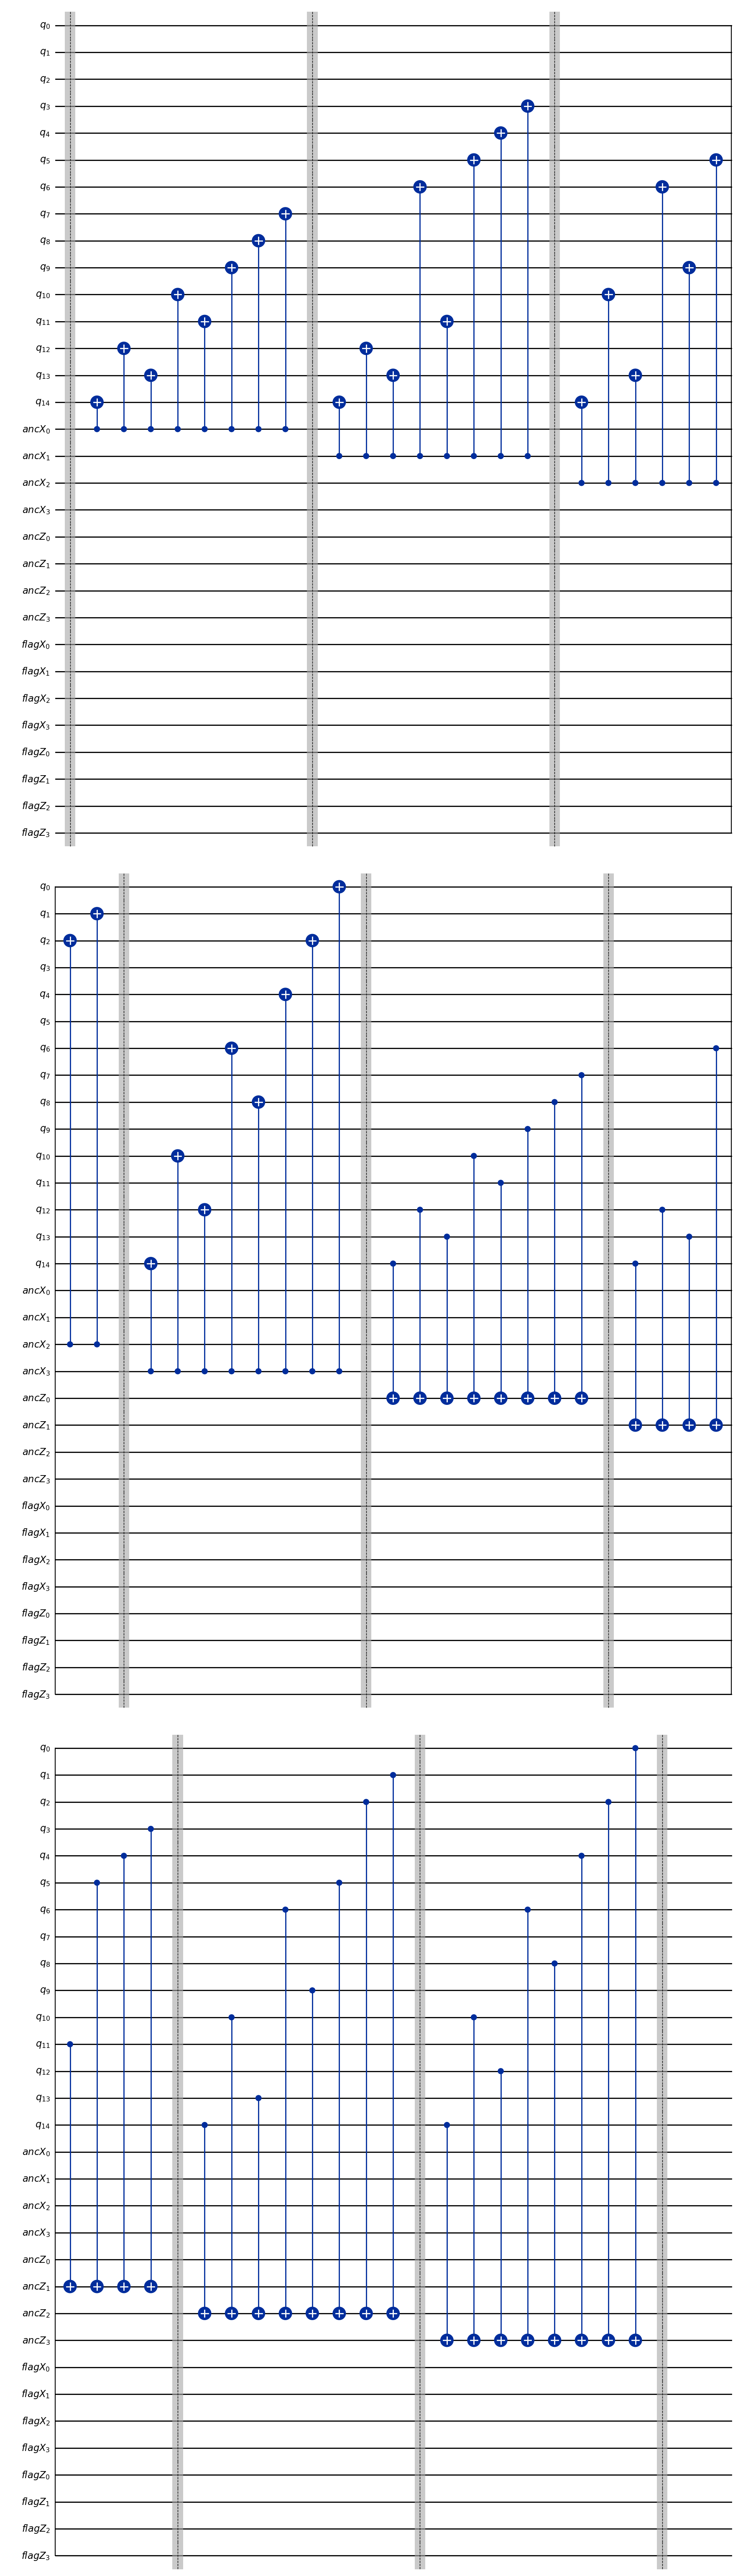

In [8]:
clean_qc = remove_flag_gates(qasm_path, save_path=dir_path + "[[5,1,3]]_[2,2]_T_no_flag.qasm")
print("Original gates:", len(clean_qc.data))
clean_qc.draw("mpl")



In [18]:
from z3 import PbGe
state, qc, sites_info, groups = build_state_with_faults_after_gates( qasm_path,bad_locations_dict, fault_mode="2q")   
#print(sites_info)
data_idxs = groups["data"]
ancz_idxs = groups["ancZ"]
flagx_idxs = groups["flagX"]
ancx_idxs = groups["ancX"]
flagz_idxs = groups["flagZ"]

print("Data qubits:", data_idxs)
print("Ancilla qubits (Z-basis):", ancz_idxs)
print("Ancilla qubits (X-basis):", ancx_idxs)
print("Flag qubits (X-basis):", flagx_idxs)
print("Flag qubits (Z-basis):", flagz_idxs)

after_flag_state_X = [state.qubits[i].x for i in data_idxs]
after_flag_state_Z = [state.qubits[i].z for i in data_idxs]

fault_var = [[v for k,v in s["vars"].items() if k.startswith("f")] for s in sites_info]
gate_fault_constr = [Or(f) for f in fault_var if f != []]



flag_err_var =  []

flag_err_var.extend(inject_on_flags(state, flagx_idxs, axis="z", prefix="flagErr"))


flag_err_var.extend(inject_on_flags(state, flagz_idxs, axis="x", prefix="flagErr"))
print("flagz_idxs", flagz_idxs)
print("flag_err_var", flag_err_var)
anc_err_var = [] 

anc_err_var.extend(inject_on_flags(state, ancx_idxs, axis="z", prefix="ancErr"))
anc_err_var.extend(inject_on_flags(state, ancz_idxs, axis="x", prefix="ancErr"))

all_fault = gate_fault_constr+ flag_err_var + anc_err_var

one_fault_constr = [ And (PbGe( [(f,1) for f in all_fault], 1), PbLe( [(f,1) for f in all_fault], 1))]



var = [sub for sub in fault_var for sub in sub] + flag_err_var + anc_err_var

ren_1 = make_renamer_from_symbols(var, "_p1")
ren_2 = make_renamer_from_symbols(var, "_p2")

one_fault_constr_p1 = primed_copy(one_fault_constr, ren_1)
one_fault_constr_p2 = primed_copy(one_fault_constr, ren_2)

print("one_fault_constr_p1", one_fault_constr_p1)
print("one_fault_constr_p2", one_fault_constr_p2)


A = [state.qubits[i].z for i in ancx_idxs] + [state.qubits[i].x for i in ancz_idxs]
F = [state.qubits[i].z for i in flagx_idxs] + [state.qubits[i].x for i in flagz_idxs]

print("Flag expr")


A_1 = primed_copy(A, ren_1)
A_2 = primed_copy(A, ren_2)
F_1 = primed_copy(F, ren_1)
F_2 = primed_copy(F, ren_2)

after_raw_state, snap = symbolic_propagate_with_resets(clean_qc ,state, track_steps= True)

E_x = [after_raw_state.qubits[i].x for i in data_idxs]
E_z = [after_raw_state.qubits[i].z for i in data_idxs]

raw_A = [after_raw_state.qubits[i].z for i in ancx_idxs] + [after_raw_state.qubits[i].x for i in ancz_idxs]

E_x_1 = primed_copy(E_x, ren_1)
E_z_1 = primed_copy(E_z, ren_1)
E_x_2 = primed_copy(E_x, ren_2)
E_z_2 = primed_copy(E_z, ren_2)

raw_A_1 = primed_copy(raw_A, ren_1)
raw_A_2 = primed_copy(raw_A, ren_2)

gen_syn_1 = A_1 + F_1 + raw_A_1
gen_syn_2 = A_2 + F_2 + raw_A_2

stab_eq , gsel = exists_stab_equiv(E_x_1, E_z_1, E_x_2, E_z_2, txt_path)




same_syn =  And( *[x == y for x, y in zip(gen_syn_1, gen_syn_2)] )

s.add(same_syn, Not(Exists(gsel, stab_eq)))
s.add(one_fault_constr_p1)
s.add(one_fault_constr_p2)


print(s.check()) 


groups detected: {'data': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'ancX': [15, 16, 17, 18], 'ancZ': [19, 20, 21, 22], 'flagX': [23, 24, 25, 26], 'flagZ': [27, 28, 29, 30]}
Processing gate 0: barrier on qubits [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Processing gate 1: cx on qubits [15, 14]
Processing gate 2: cx on qubits [15, 27]
Processing gate 3: cx on qubits [15, 12]
Processing gate 4: cx on qubits [15, 13]
Processing gate 5: cx on qubits [15, 10]
Processing gate 6: cx on qubits [15, 11]
Processing gate 7: cx on qubits [15, 9]
Processing gate 8: cx on qubits [15, 8]
Processing gate 9: cx on qubits [15, 27]
Processing gate 10: cx on qubits [15, 7]
Processing gate 11: barrier on qubits [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Processing gate 12: cx on qubits [16, 14]
Processing gate 13: cx on qubits [16, 29]
Processing gate 14:

In [ ]:
for d in s.model().decls(): 
    
    val = s.model()[d]
    if str(val)  == "True": 
        print(f"{d.name()} = {val}")


Z3Exception: model is not available

In [19]:


val_1 =  {"faulty_gate19_z0" : True}
val_2 =   {"flagErr23_z" : True}

for i in range(len(A)): 
    print(f"A_{i}", eval_with_values(A[i], val_1),  eval_with_values(A[i], val_2))
for i in range(len(F)): 
    print(f"F_{i}", eval_with_values(F[i], val_1), eval_with_values(F[i], val_2))

for i in range(len(raw_A)): 
    print(f"raw_A_{i}", eval_with_values(raw_A[i], val_1) , eval_with_values(raw_A[i], val_2))

A_0 False False
A_1 True False
A_2 False False
A_3 False False
A_4 False False
A_5 False False
A_6 False False
A_7 False False
F_0 False True
F_1 False False
F_2 False False
F_3 False False
F_4 False False
F_5 False False
F_6 False False
F_7 False False
raw_A_0 False False
raw_A_1 False False
raw_A_2 False False
raw_A_3 False False
raw_A_4 False False
raw_A_5 False False
raw_A_6 False False
raw_A_7 False False


In [19]:




val_1 =  {"faulty_gate19_z0_p1" : True}
val_2 =   {"flagErr23_z_p2" : True}

for E in E_x_1:
   
    val  = eval_with_values(E, val_1)
    print("E_x_1", val)

for E in E_z_1:
    val  = eval_with_values(E, val_1)
    print("E_z_1", val)

for E in E_x_2:
   val  = eval_with_values(E, val_2)
   print("E_x_2", val)

for E in E_z_2:
   val  = eval_with_values(E, val_2)
   print("E_z_2", val)


for A in A_1:
    val  = eval_with_values(A, val_1)
    print("A_1", val)
for F in F_1:
    val  = eval_with_values(F, val_1)
    print("F_1", val)

for A in A_2:
    val  = eval_with_values(A, val_2)
    print("A_2", val)
for F in F_2:
    val  = eval_with_values(F, val_2)
    print("F_2", val)

for raw_A in raw_A_1:
    val  = eval_with_values(raw_A, val_1)
    print("raw_A_1", val)

for raw_A in raw_A_2:
    val  = eval_with_values(raw_A, val_2)
    print("raw_A_2", val)


E_x_1 False
E_x_1 False
E_x_1 False
E_x_1 False
E_x_1 False
E_x_1 False
E_x_1 False
E_x_1 False
E_x_1 False
E_x_1 False
E_x_1 False
E_x_1 False
E_x_1 False
E_x_1 False
E_x_1 False
E_z_1 False
E_z_1 False
E_z_1 False
E_z_1 False
E_z_1 False
E_z_1 False
E_z_1 False
E_z_1 False
E_z_1 False
E_z_1 False
E_z_1 False
E_z_1 False
E_z_1 False
E_z_1 False
E_z_1 False
E_x_2 False
E_x_2 False
E_x_2 False
E_x_2 False
E_x_2 False
E_x_2 False
E_x_2 False
E_x_2 False
E_x_2 False
E_x_2 False
E_x_2 False
E_x_2 False
E_x_2 False
E_x_2 False
E_x_2 False
E_z_2 False
E_z_2 False
E_z_2 False
E_z_2 False
E_z_2 False
E_z_2 False
E_z_2 False
E_z_2 False
E_z_2 False
E_z_2 False
E_z_2 False
E_z_2 False
E_z_2 False
E_z_2 False
E_z_2 False
A_1 False
A_1 True
A_1 False
A_1 False
A_1 False
A_1 False
A_1 False
A_1 False
F_1 False
F_1 False
F_1 False
F_1 False
F_1 False
F_1 False
F_1 False
F_1 False
A_2 False
A_2 False
A_2 False
A_2 False
A_2 False
A_2 False
A_2 False
A_2 False
F_2 True
F_2 False
F_2 False
F_2 False
F_